In [5]:
import os, shutil, random
import os
import zarr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# make a small subset of img dataset for testing 
# Define source and destination directories
# source_dir = "/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/projections"
# destination_dir = "/glade/derecho/scratch/joko/synth-ros/params_200_50_small_subset/projections"

# # Define the number of PNGs to keep per folder (adjust as needed)
# num_keep = 10  # Change this value to set the subset size

# # Ensure destination directory exists
# os.makedirs(destination_dir, exist_ok=True)

# # Loop through subdirectories
# for subdir in os.listdir(source_dir):
#     subdir_path = os.path.join(source_dir, subdir)
#     dest_subdir_path = os.path.join(destination_dir, subdir)

#     if os.path.isdir(subdir_path):  # Check if it's a directory
#         os.makedirs(dest_subdir_path, exist_ok=True)  # Create corresponding subdir

#         # Get list of PNG files in the current subdir
#         png_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(".png")]

#         # Select a random subset
#         selected_files = random.sample(png_files, min(num_keep, len(png_files)))

#         # Copy selected files to the destination
#         for file in selected_files:
#             src_file_path = os.path.join(subdir_path, file)
#             dest_file_path = os.path.join(dest_subdir_path, file)
#             shutil.copy2(src_file_path, dest_file_path)

# print(f"✅ Successfully copied a random subset of PNG files to {destination_dir}")


In [6]:
# List to store images
image_list = []
image_paths = []
source_dir = "/glade/derecho/scratch/joko/synth-ros/params_200_50_small_subset/projections"
# Loop through directories to find PNG files
for root, _, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith(".png"):  # Only process PNG images
            img_path = os.path.join(root, file)
            img = Image.open(img_path).convert('L') # Convert to grayscale
            img_arr = np.array(img)
            image_list.append(img_arr)
            image_paths.append(img_path)
len(image_list)

70

In [7]:
images_np = np.stack(image_list, axis=0)
images_np.shape

(70, 128, 128)

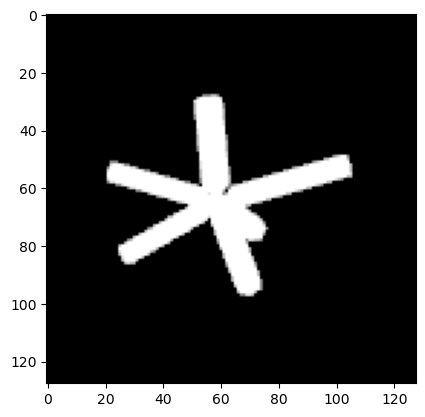

In [8]:
i = random.randint(0,69)
img = images_np[i,:,:]
plt.imshow(img, cmap='gray')

In [66]:
# create a zarr file from all the images
# Define source directory where images are stored
source_dir = "/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/projections"

# Define destination Zarr file
zarr_file = "/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/projections/projections.zarr"

# get list of all img paths
relative_paths_txt = os.path.join(source_dir, 'img_relative_paths.txt')
# Open the file and read lines into a list
with open(relative_paths_txt, "r") as file:
    lines = file.readlines()  # Includes newline characters
relative_paths = [line.strip() for line in lines]
png_files=[]
for p in relative_paths:
    full_path = os.path.join(source_dir, p.split('/',1)[1])
    png_files.append(full_path)
# Open a Zarr group (or create one if it doesn't exist)
zarr_group = zarr.create_group(zarr_file, overwrite=True)
n_chunk = 10000
n_data = len(png_files)
# Store in Zarr
images = zarr_group.create_array("images", shape=(n_data, 128, 128), chunks=(n_chunk, 128, 128), dtype=np.float64)
paths = zarr_group.create_array("paths", shape=(n_data,), chunks=(n_chunk,), dtype=object)  # Store file paths as metadata

# # List to store images
# image_list = []
# image_paths = []

for i in range(0, n_data, n_chunk):
    print(f'i: {i}')
    batch_size = min(n_chunk, n_data - i)
    print(f'batch_size: {batch_size}')
    img_list = []
    for j in range(i, i+batch_size):
        img_path = png_files[j]
        img = Image.open(img_path).convert('L') # Convert to grayscale
        img_arr = np.array(img)
        img_list.append(img_arr)
    images_np = np.stack(img_list, axis=0)
    images[i:(i+batch_size)] = images_np
    paths[i:(i+batch_size)] = png_files[i:(i+batch_size)]

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


i: 0
batch_size: 10000
i: 10000
batch_size: 10000
i: 20000
batch_size: 10000


KeyboardInterrupt: 

/glade/derecho/scratch/joko/synth-ros/params_200_50_small_subset/projections/6/ros-projection-028524-041.png


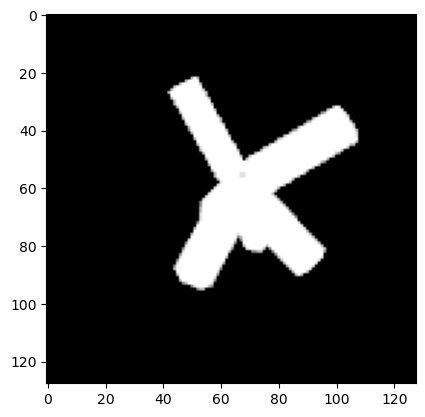

In [54]:
i = random.randint(0,len(png_files))
img = images[i]
filename = paths[i]
print(filename)
plt.imshow(img, cmap='gray')

In [55]:
print(type(images))
print(type(paths))

<class 'zarr.core.array.Array'>
<class 'list'>


In [52]:
list(zarr_group.keys())

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


['images', 'paths']

In [53]:
print(zarr_group['paths'].info)

Type               : Array
Zarr format        : 3
Data type          : DataType.string
Shape              : (70,)
Chunk shape        : (70,)
Order              : C
Read-only          : False
Store type         : LocalStore
Filters            : ()
Serializer         : VLenUTF8Codec()
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 560


In [47]:
print(zarr.__version__)

3.0.1
